# <h1 align="center">EDA and Model Analysis</h1>

## Data
**I retrieved my dataset from the following link: https://www.kaggle.com/datasets/pooriamst/best-books-ever-dataset/data. The dataset contains 25 variables and 52478 records corresponding to books on the GoodReads Best Books Ever list. This is a list of The best books ever, as voted on by the general Goodreads community.**

## Problem Definition
I'm curious to understand why readers chose the books they did as "the best books ever". I'm planning on comparing the relative position of a book in the list (bbeVotes) to its rating, total number of awards, number of ratings, and likedPercent.

Type of Problem: Supervised Learning: Regression problem. 

## Objective:
Predict the rank of a book based on its rating and total number of awards.

In [1]:
# Supervised Learning problem to perform EDA and model analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('D:\\repo\\eda-model-analysis-supervised-learning\\dataset\\bestBooks.csv')

print(df.head())

                                        bookId  \
0                     2767052-the-hunger-games   
1  2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                   2657.To_Kill_a_Mockingbird   
3                     1885.Pride_and_Prejudice   
4                               41865.Twilight   

                                       title                 series  \
0                           The Hunger Games    The Hunger Games #1   
1  Harry Potter and the Order of the Phoenix        Harry Potter #5   
2                      To Kill a Mockingbird  To Kill a Mockingbird   
3                        Pride and Prejudice                    NaN   
4                                   Twilight   The Twilight Saga #1   

                                      author  rating  \
0                            Suzanne Collins    4.33   
1  J.K. Rowling, Mary GrandPré (Illustrator)    4.50   
2                                 Harper Lee    4.28   
3  Jane Austen, Anna Quindlen (Introduction)    

In [2]:
# General information about the dataset
print("Shape: ", df.shape)
df.info()
df.describe(include='all')
df.isnull().sum()


Shape:  (52478, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            52478 non-null  object 
 1   title             52478 non-null  object 
 2   series            23470 non-null  object 
 3   author            52478 non-null  object 
 4   rating            52478 non-null  float64
 5   description       51140 non-null  object 
 6   language          48672 non-null  object 
 7   isbn              52478 non-null  object 
 8   genres            52478 non-null  object 
 9   characters        52478 non-null  object 
 10  bookFormat        51005 non-null  object 
 11  edition           4955 non-null   object 
 12  pages             50131 non-null  object 
 13  publisher         48782 non-null  object 
 14  publishDate       51598 non-null  object 
 15  firstPublishDate  31152 non-null  object 
 16  awards            52

bookId                  0
title                   0
series              29008
author                  0
rating                  0
description          1338
language             3806
isbn                    0
genres                  0
characters              0
bookFormat           1473
edition             47523
pages                2347
publisher            3696
publishDate           880
firstPublishDate    21326
awards                  0
numRatings              0
ratingsByStars          0
likedPercent          622
setting                 0
coverImg              605
bbeScore                0
bbeVotes                0
price               14365
dtype: int64

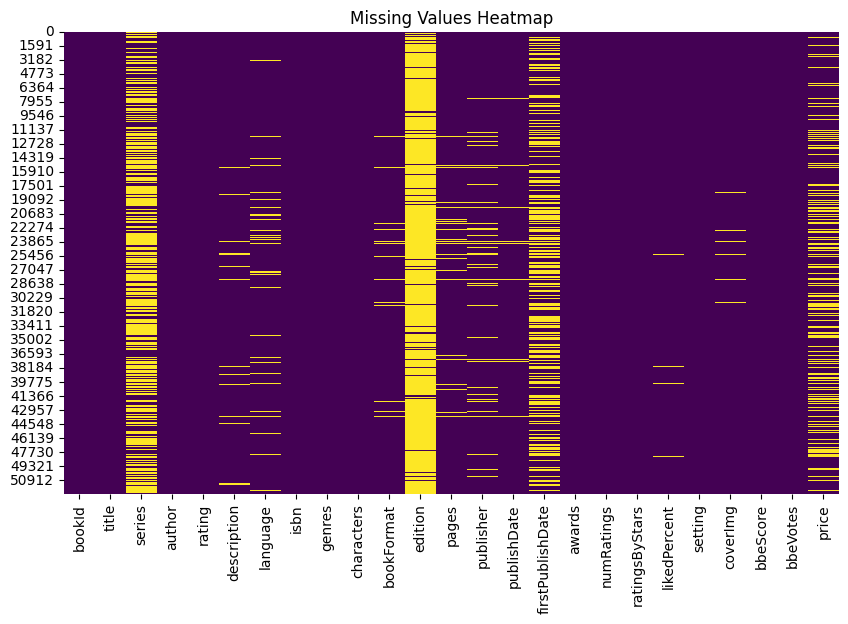

In [3]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### As you see above, most of the missing values are in features we are not using for the analysis, such as series, edition, and price.

During the Data Cleaning portion of the project, we will be removing all columns that are of no interest to the analysis.

## **CLEANING THE DATA**

In [4]:
# VERY IMPORTANT > Convert awards to numeric - Since awards is a feature of interest, I need to convert it to a numeric value (sum of awards).
df['awards_count'] = df['awards'].apply(lambda x: len(eval(x)) if x != '[]' else 0) # isn't Python beautiful?

# Convert necessary columns to numeric
df['numRatings'] = pd.to_numeric(df['numRatings'], errors='coerce')
df['likedPercent'] = pd.to_numeric(df['likedPercent'], errors='coerce')
df['bbeVotes'] = pd.to_numeric(df['bbeVotes'], errors='coerce')

# FEATURE ENGINEERING
# Apply log transformation to numRatings and awards_count
# Since the vast majority of books have 0 awards, the distribution is heavily skewed to the right, which is why I'm using a log transformation.
# Similar issue with numRatings, since some books have millions of ratings and some have close to 0.
df['log_numRatings'] = np.log1p(df['numRatings'])
df['log_awards_count'] = np.log1p(df['awards_count'])
df['log_bbeVotes'] = np.log1p(df['bbeVotes'])

df.columns = df.columns.str.strip() # Remove leading and trailing whitespace from column to ensure consistency and prevent errors 
# when referencing column names in code

# Drop rows with NaN values in key features - I decided to drop these rows instead of using mean or median imputation because
# the data is not missing in a way that would affect the analysis.
df.dropna(subset=['rating', 'log_numRatings', 'likedPercent', 'log_bbeVotes'], inplace=True) # Do not drop NaN values in awards_count, as 0 is an acceptable value

# Feature selection
features = ['rating', 'log_awards_count', 'log_numRatings', 'likedPercent', 'log_bbeVotes']

# Replace infinities with large finite numbers and then drop them
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=features, inplace=True) 

# drop all other columns
df = df[features]

print(df.columns)

# Normalize/Standardize features - this is especially important for my linear regression model below (more on this below)
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Handle duplicates
df.drop_duplicates(inplace=True)

# Outlier detection and handling for 'rating' - IQR method
q1 = df['rating'].quantile(0.25)
q3 = df['rating'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['rating'] >= lower_bound) & (df['rating'] <= upper_bound)]

# cleaned data
print(df.head())

Index(['rating', 'log_awards_count', 'log_numRatings', 'likedPercent',
       'log_bbeVotes'],
      dtype='object')
     rating  log_awards_count  log_numRatings  likedPercent  log_bbeVotes
0  0.936410          7.734880        3.330054      0.629250      9.728701
1  1.454552          4.590517        2.951879      0.963181      9.596121
2  0.784015          3.071787        3.188908      0.462285      9.444431
3  0.723057         -0.454595        3.024283      0.295319      9.305181
4 -1.288552          6.684105        3.228616     -2.376128      8.968140


## **General reminder on StandardScaler**
**StandardScaler transforms the data such that it has a mean of 0 and a standard deviation of 1, which is crucial for many machine learning models, particularly those sensitive to feature scales like linear regression.** That's why, if you pay attention to the results above, "awards_count" can be a fraction or even a negative number. 
- For example:
A negative awards count means that book's total sum of awards is under the overall mean. 

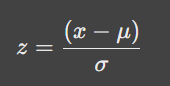

- x is the original value.

- μ is the mean of the feature.

- σ is the standard deviation of the feature.

### Why Standardize?
For linear regression (and many ML models), standardizing can help with:

- Convergence during training (features with vastly different scales can confuse the model).

- Comparing feature importance (coefficients) on a similar scale.

## **Data Cleaning - Conclusion and Discussion**
- Summary: The data cleaning process involved standardizing formats, handling missing values, and ensuring data integrity through removing duplicates and outlier removal.

- Findings: The dataset is fairly clean, with only a few missing values in some columns, which were addressed through imputation or removal.

- Challenges: Balancing data completeness with the need to remove unreliable data was a key challenge.

- Strategy: Focused on retaining as much data as possible while ensuring quality for analysis and modeling.


## **EDA AND VISUALIZATION**
### Features' distribution of Standardized Data

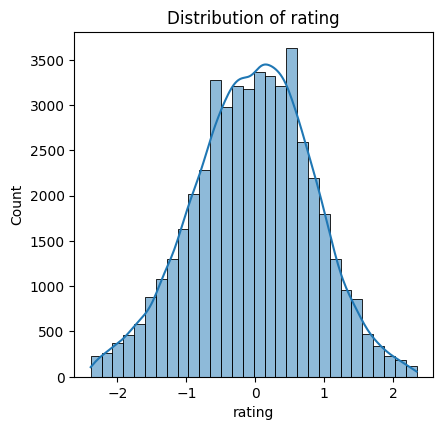

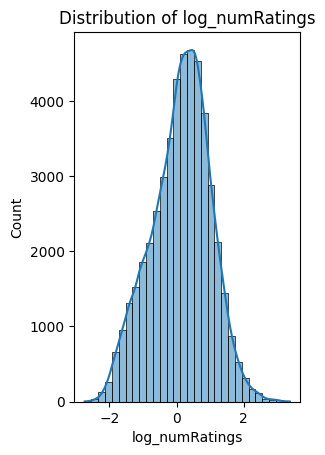

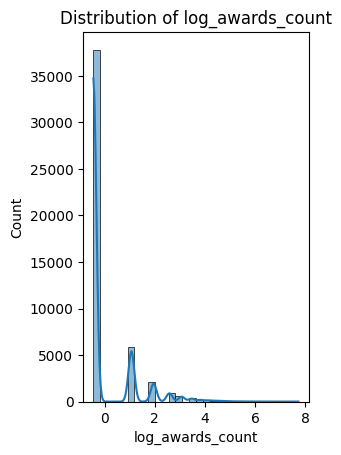

In [6]:
# EDA: Visualize distributions of key features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features[0:1], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# EDA: Visualize distribution of log-transformed numRatings - This transformation compresses the scale, 
# making large values more manageable and the graph more readable.
# Log-transformed numRatings
plt.subplot(1, 2, 2)
sns.histplot(df['log_numRatings'], kde=True, bins=30)
plt.title('Distribution of log_numRatings')
plt.xlabel('log_numRatings')
plt.ylabel('Count')
plt.show()

# Log-transformed awards_count
plt.subplot(1, 2, 1)
sns.histplot(df['log_awards_count'], kde=True, bins=30)
plt.title('Distribution of log_awards_count')
plt.xlabel('log_awards_count')
plt.ylabel('Count')
plt.show()


### Comparing different features to bbeVotes

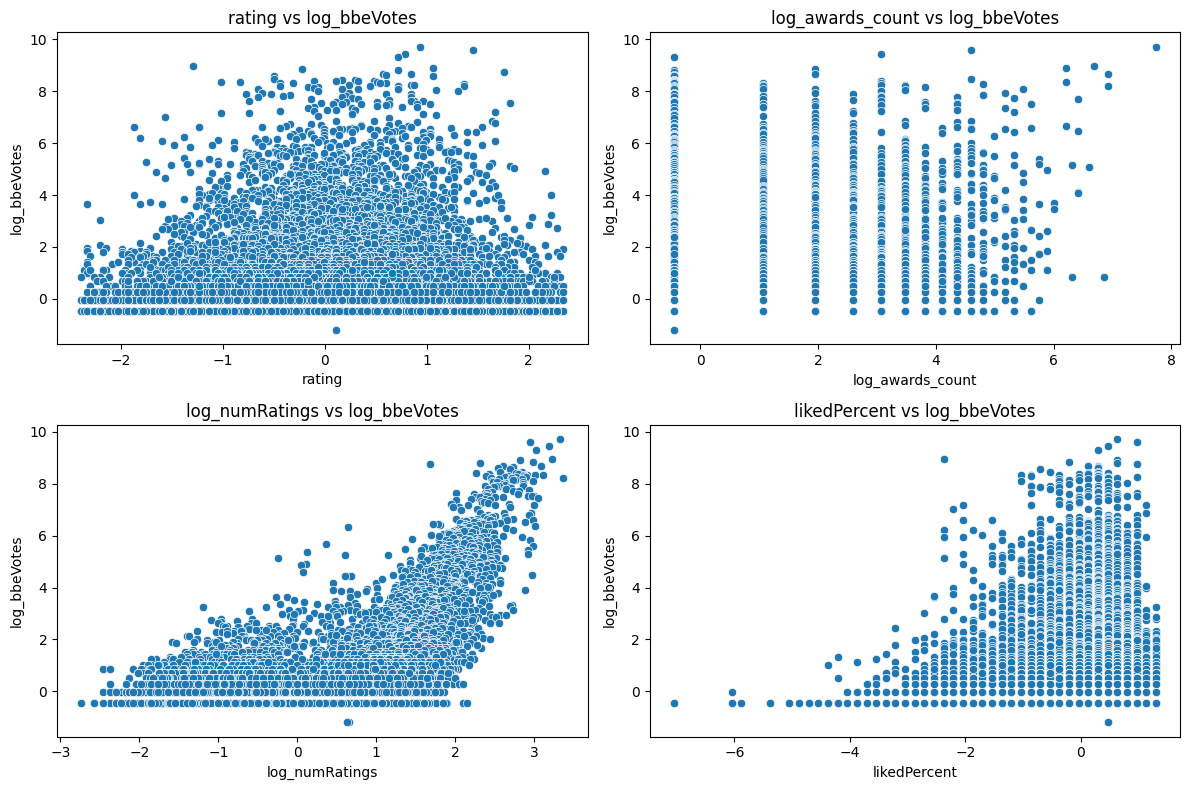

In [5]:
# Features to compare with bbeVotes
comparison_features = features[0:4]

# Visualize relationships with bbeVotes
plt.figure(figsize=(12, 8))
for i, feature in enumerate(comparison_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[feature], y=df['log_bbeVotes'])
    plt.title(f'{feature} vs log_bbeVotes')
    plt.xlabel(feature)
    plt.ylabel('log_bbeVotes')
plt.tight_layout()
plt.show()



## **EDA analysis and conclusions**
### Rating Vs bbeVotes
- Rating has a weak but positive effect on bbeVotes, but it is not the strongest predictor.

- High bbeVotes is more common at higher rating values, but it is not guaranteed.

### log_awards_count vs log_bbeVotes
- Winning more awards slightly increases the likelihood of getting more bbeVotes, but it is not a strong predictor.

- Many books with zero awards still get significant votes, suggesting awards are not a primary driver.

### log_numRatings vs log_bbeVotes
- log_numRatings is the strongest predictor of log_bbeVotes among the features analyzed.

- This makes sense: popular books (more ratings) tend to have more fans who vote for them.

### likedPercent vs log_bbeVotes
- likedPercent has some effect on bbeVotes, but it is not a strong predictor.

- A high percentage of people liking a book does not necessarily mean that book gets a lot of "Best Book Ever" votes.

- Other factors, such as the number of ratings, play a bigger role.


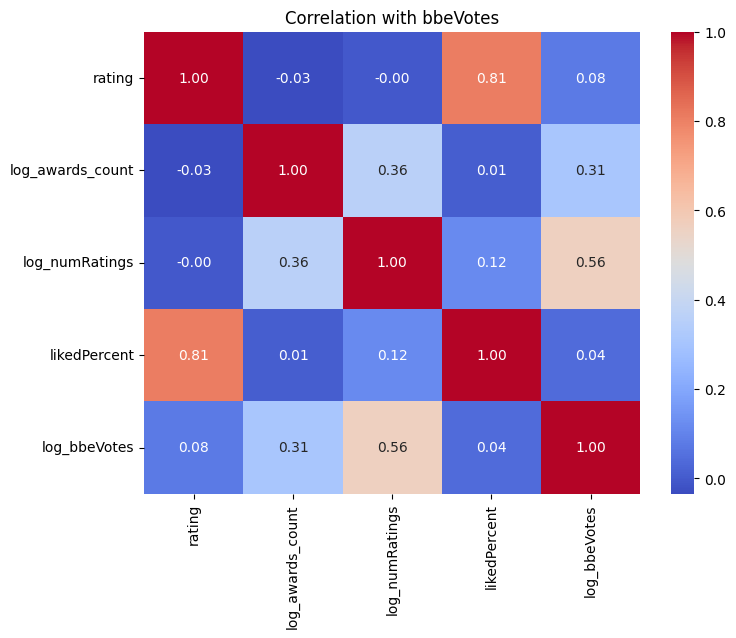

In [7]:
# Correlation analysis

corr_matrix_bbeVotes = df[comparison_features + ['log_bbeVotes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_bbeVotes, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with bbeVotes')
plt.show()

## **Correlation matrix analysis**
### Correlation with bbeVotes
- log_numRatings shows the strongest positive correlation with log_bbeVotes (0.56). In other words, books with more total ratings tend to receive more “Best Book Ever” votes.

- log_awards_count has a moderate positive correlation (0.31), suggesting that award‐winning books also tend to get more BBE votes, though not as strongly as more widely rated books.

- rating (0.08) and likedPercent (0.04) each have only a mild positive relationship with log_bbeVotes. That means a higher average rating or percentage of likes doesn’t necessarily translate strongly into more BBE votes, at least not as clearly as raw popularity (numRatings) or formal recognition (awards).

### Feature Interactions
- rating and likedPercent (0.81):
There is a strong positive correlation between these two features. This is expected, as higher average ratings are likely accompanied by a higher percentage of people who "liked" the book.


## **Single Model 1 - Linear Regression**

Reasons to start with a linear regression model:
- Provide a baseline. I can use this model to compare the performance of other models.

- Linear models are computationally less intensive compared to non-linear models, making them suitable for large datasets such as this one.

- Linear models are easier to interpret and understand, making it easier to understand the relationship between the features and the target variable.


Problem: Predict the rank of a book based on its rating, total number of awards, likedpercent, and number of ratings.
To achieve this, I'll use a linear regression model. The data will be split into training and testing sets, and the model will be trained on the training set and evaluated on the testing set.

To evaluate the model, I'll use the root mean squared error (RMSE) and R-squared metrics.

In [10]:
X = df[comparison_features]
y = df['log_bbeVotes'] #target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# predictions
y_pred = model.predict(X_test)

# Ensure y_test and y_pred are numeric arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# R²
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# results interpretation
coefficients = model.coef_
feature_importance_lr = pd.DataFrame(coefficients, X.columns, columns=['Coefficient'])
feature_importance_lr = feature_importance_lr.sort_values(by='Coefficient', ascending=False)
print(feature_importance_lr)

RMSE: 0.8074387441058468
R²: 0.3658099747819441
                  Coefficient
log_numRatings       0.640792
rating               0.366589
log_awards_count     0.125958
likedPercent        -0.343489


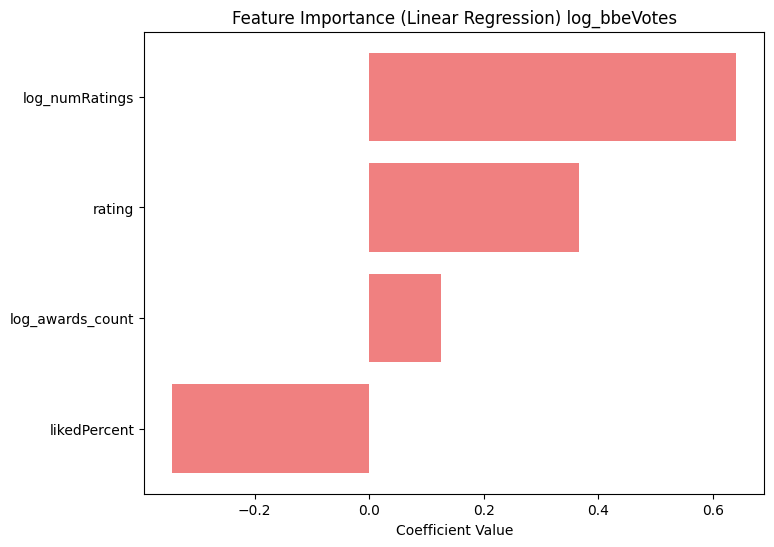

In [13]:
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_lr.index, feature_importance_lr['Coefficient'], color='lightcoral')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Linear Regression) log_bbeVotes')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


## **Single Model 2 - Random Forest Regressor**

I will construct multiple decision trees during training and output the mean prediction of the individual trees, which will hopefully help me understand the relationship between the features and the target variable.

Reasons to use a Random Forest Regressor:

- Handle Non-Linearity: it can capture complex relationships between features and the target variable.

- Robust to overfitting: Generally more robust to overfitting than individual decision trees, especially with a large number of trees.

- Feature Importance: Provides insights into feature importance, which can be useful for understanding the model.


In [14]:
# log-transformed bbeVotes
X = df[comparison_features]
y = df['log_bbeVotes'] # log-transformed target


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest on the log-transformed target
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict in log space
y_pred_log = rf_model.predict(X_test)

# Evaluate in log space
mse_log = mean_squared_error(y_test, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred_log)

print(f'RMSE (log scale): {rmse_log}')
print(f'R² (log scale): {r2_log}')

# Feature importance
feature_importance_rf = pd.DataFrame(rf_model.feature_importances_, X.columns, columns=['Importance'])
feature_importance_rf = feature_importance_rf.sort_values(by="Importance", ascending=False)
print(feature_importance_rf)

RMSE (log scale): 0.6072480841409311
R² (log scale): 0.641299035792156
                  Importance
log_numRatings      0.821357
rating              0.099175
likedPercent        0.052284
log_awards_count    0.027183


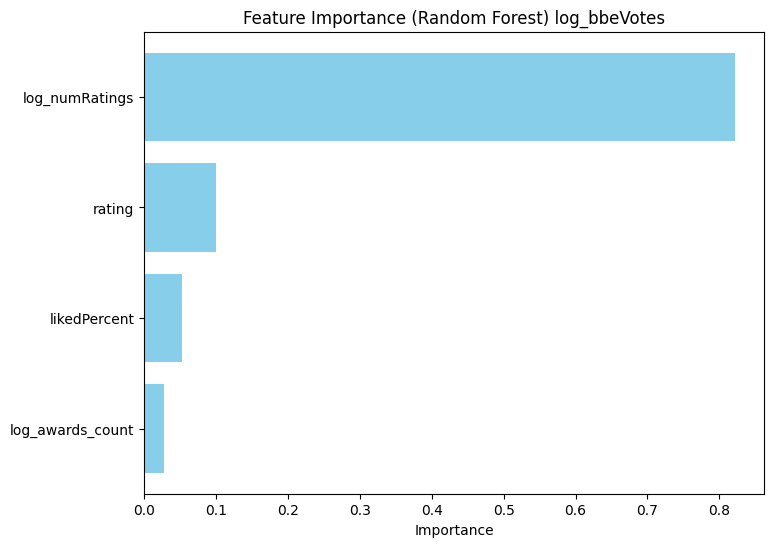

In [12]:
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_rf.index, feature_importance_rf['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest) log_bbeVotes')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# DISCUSSION AND CONCLUSIONS
## **Linear Regression**
- R² ≈ 0.64: the model explains about 64% of the variance in Best bbeVotes. That suggests these four predictors capture a significant portion of what drives BBE votes though there is still room for other unmeasured factors. 

- The RMSE ≈ 0.61 on the log scale translates to moderate predictive error for bbeVotes. It’s decent for a simple linear model but not necessarily tight.

### Coefficients
- log_numRatings has by far the largest positive coefficient (≈ 0.82). This implies that as the number of ratings increases, so do BBE votes—likely indicating the importance of sheer popularity or exposure.

- rating and likedPercent are both positive but smaller in effect. Higher‐rated books do tend to get more BBE votes, but the impact of rating/like‐percent is modest compared to total volume of ratings.

- log_awards_count also has a positive but modest relationship (≈ 0.03). Winning more awards is associated with more BBE votes, though not nearly as strongly as simply having a large reader base.

## **Random Forest Regressor**
- This model achieved an R² of approximately 0.64 (in log space) on the test set, which means it explains about 64% of the variation in the log of BBE votes.

- The RMSE of about 0.61 (log scale) indicates that while the model’s predictions are reasonably accurate in log space, there is still some unexplained variability.

### Coefficients
- Log_numRatings is by far the most influential predictor for log_bbeVotes. In other words, the more total ratings a book has, the more likely it is to also have higher Best Book Ever votes.

- Rating, likedPercent, and log_awards_count also contribute to the model, but to a much smaller degree. This aligns with the notion that overall popularity (i.e., many readers) has a larger impact than average rating or award recognition.

## FINAL CONCLUSION
BOTH MODELS SEEM TO INDICATE THAT THE NUMBER OF RATINGS IS THE GREATEST PREDICTOR OF BEST BOOK EVER VOTES, AND THAT BBEVOTES PREDICTIONS COULD BENEFIT FROM ADDING MORE FEATURES TO THE MODELS.